In [105]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [106]:
import numpy as np
import pandas as pd

In [107]:
import datetime as datetime
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [108]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [109]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [110]:
# reflect an existing database into a new model
Base = automap_base()

#reflect tables
Base.prepare(engine, reflect=True)


In [111]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [112]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [113]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [114]:
# Listing column names 
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for name in columns:
    print(name['name'], name["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [115]:
# Listing column names 
inspector = inspect(engine)

columns = inspector.get_columns('station')
for name in columns:
    print(name['name'], name["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [116]:
# Example of date format in measurement table 
date_format = session.query(measurement.date).limit(5)
for result in date_format:
    print(result)


('2010-01-01',)
('2010-01-02',)
('2010-01-03',)
('2010-01-04',)
('2010-01-06',)


# Exploratory Climate Analysis

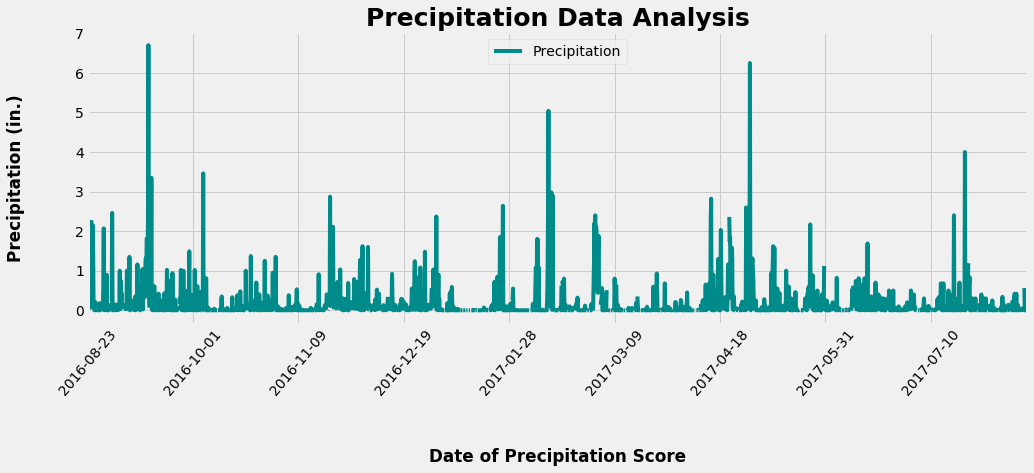

In [163]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = session.query(func.max(measurement.date)).all()
# print(one_year_ago)

# Database runs through August 23, 2017. 
# Need to filter date from same date one year ago

# Design a query to retrieve the last 12 months of precipitation data and plot the results
prcp_data = session.query(measurement.date, measurement.prcp).filter(
        measurement.date >= "2016-08-23").\
        order_by(measurement.date).all()
# pprint(prcp_data[:10])

# Perform a query to retrieve the data and precipitation scores
scores = session.query(measurement.date, measurement.prcp).order_by(
            measurement.date.desc()).all()

# pprint(scores[:5])


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_data, columns=["Date", 'Precipitation'])
df.set_index("Date", inplace=True)
df.head()

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,7))

df.plot(ax=ax, x_compat=True, figsize=(15,5), color='darkcyan')

plt.title("Precipitation Data Analysis", fontsize=25, weight='bold')
plt.legend(loc='upper center')
plt.xticks(rotation=50)
ax.set_ylabel('Precipitation (in.)', labelpad=50, weight='bold')
ax.set_xlabel('Date of Precipitation Score', labelpad=50, weight='bold')

plt.show()

In [172]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df.describe()
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [175]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(station.id).distinct().count()
print(f"There are {total_stations} stations total.")

There are 9 stations total.


In [179]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(
    station.station, func.count(
measurement.id)).select_from(measurement).\
                join(station, measurement.station == station.station).group_by(
                station.station).\
                order_by(func.count(measurement.id).desc()).all()

for result in station_count:
    print(f"Station: {result[0]} - Count: {result[1]}")

Station: USC00519281 - Count: 2772
Station: USC00519397 - Count: 2724
Station: USC00513117 - Count: 2709
Station: USC00519523 - Count: 2669
Station: USC00516128 - Count: 2612
Station: USC00514830 - Count: 2202
Station: USC00511918 - Count: 1979
Station: USC00517948 - Count: 1372
Station: USC00518838 - Count: 511


In [186]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station.
active_station = 'USC00519281'

temps= session.query(func.min(measurement.tobs), func.max(measurement.tobs), 
                     func.avg(measurement.tobs)).\
                        filter(measurement.station == active_station).all()

# pprint(temps)

print(f"Lowest Temperature: {temps[0][0]}°F")
print(f"Highest Temperature: {temps[0][1]}°F")
print(f"Average Temperature: {round(temps[0][2], 1)}°F")

Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.7°F


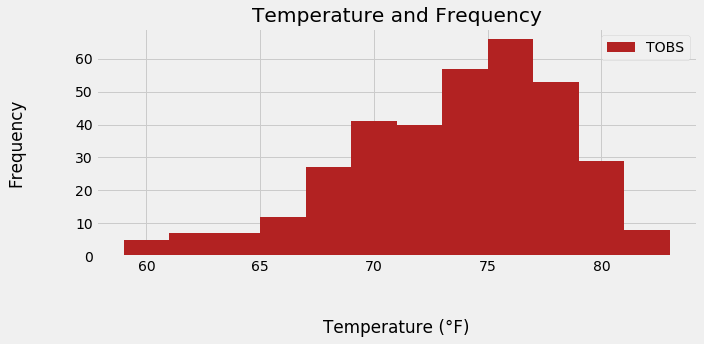

In [200]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(measurement.tobs).\
                filter(measurement.date >= "2016-08-23").\
                filter(measurement.station == 'USC00519281').\
                order_by(measurement.date).all()

tobs_df = pd.DataFrame(tobs_data, columns=["TOBS"])

tobs_df.plot.hist(bins=12, title="Temperature and Frequency", figsize=(10,5), color='firebrick')
plt.xlabel("Temperature (°F)", labelpad=45)
plt.ylabel("Frequency", labelpad=50)


plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [202]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), 
                         func.avg(measurement.tobs), 
                         func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

my_trip = calc_temps('')

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
